In [1]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import pylab as plt
import statsmodels.api as sm
import numpy as np
warnings.filterwarnings('ignore')


In [2]:
#Leemos con pandas el csv
df = pd.read_csv('C:/Users/Usuario/Desktop/ANA/UNIVERSIDAD/SEGUNDO/IRONHACK/Trabajo final/regression_datacsv.csv', delimiter = ';')
print(df.head())


           id        date  bedrooms bathrooms  sqft_living  sqft_lot floors  \
0  7129300520  13/10/2014         3         1         1180      5650      1   
1  6414100192  09/12/2014         3      2,25         2570      7242      2   
2  5631500400  25/02/2015         2         1          770     10000      1   
3  2487200875  09/12/2014         4         3         1960      5000      1   
4  1954400510  18/02/2015         3         2         1680      8080      1   

   waterfront  view  condition  ...  sqft_above  sqft_basement  yr_built  \
0           0     0          3  ...        1180              0      1955   
1           0     0          3  ...        2170            400      1951   
2           0     0          3  ...         770              0      1933   
3           0     0          5  ...        1050            910      1965   
4           0     0          3  ...        1680              0      1987   

   yr_renovated  zipcode      lat      long sqft_living15  sqft_lot1

In [3]:
#Examinamos el csv
print('COLUMNAS')
print(df.columns)
print('\n')
print('INFO')
df.info()
#Observación: 
#columnas no numércicas: date, bathrooms(arreglar), floors(arreglar), lat(arreglar), long(arreglar)
#En principio no se ve ningún dato nulo  
#Como queremos predecir el precio, la columna que va a ir por separado es price
#Para predecir el precio necesitamos: bedrooms, bathrooms, sqft (los examinamos para ver si los podemos agrupar), floors, condiciones, grade, year_built, year_renovate, waterview
#lat, long y zipcode no nos influye ya que estan todas las casas en la misma zona de Seattle, Tacoma y alrededores (hemos buscado en google maps)


COLUMNAS
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')


INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             21597 non-null  int64 
 1   date           21597 non-null  object
 2   bedrooms       21597 non-null  int64 
 3   bathrooms      21597 non-null  object
 4   sqft_living    21597 non-null  int64 
 5   sqft_lot       21597 non-null  int64 
 6   floors         21597 non-null  object
 7   waterfront     21597 non-null  int64 
 8   view           21597 non-null  int64 
 9   condition      21597 non-null  int64 
 10  grade          21597 non-null  int64 
 11  sqft_above     

In [4]:
#Pasamos a la limpieza de los datos

#Hacemos copia de los datos
df_copia = df.copy()


In [5]:
#Vamos a redondear los numeros decimales que no tienen sentido, como 2.25 baños

def redondear(columna):
    for i in range(len(df)):
        if ',' in df[columna][i]:
            df[columna][i] = float(df[columna][i].replace(',', '.'))
            df[columna][i] = round(df[columna][i])
    return df

redondear('bathrooms')
print(df['bathrooms'])
redondear('floors')
print(df['floors'])

0        1
1        2
2        1
3        3
4        2
        ..
21592    2
21593    2
21594    1
21595    2
21596    1
Name: bathrooms, Length: 21597, dtype: object
0        1
1        2
2        1
3        1
4        1
        ..
21592    3
21593    2
21594    2
21595    2
21596    2
Name: floors, Length: 21597, dtype: object


In [6]:
#Ahora vamos a quitar las columnas que no nos hacen falta: lat, long, date, zipcode
#lat y long no hacen falta porque todas las casas están en la misma zona
#zipcode por la misma razón

df = df.drop(columns = ['date', 'lat', 'long', 'zipcode'], axis = 1)

In [7]:
#Para simplificar el análisis, vamos a agrupar todas las columnas que tengan las maediciones de metros cuadrados, haciendo una única columna que diga todos los metros cuadrados de la casa.
#Tendremos al final dos columnas: la medida del terreno (lot) y la medida de la casa (living)
#No nos interesan las medidas anteriores a las reformas ya que no existen. 
#above y basement los quitamos ya que living es la suma de estas, y en el precio influyen los metos cuadrados totales
df = df.drop(columns = ['sqft_above', 'sqft_basement', 'sqft_living', 'sqft_lot'], axis = 1)
print(df.head())
print(df.columns)

           id  bedrooms bathrooms floors  waterfront  view  condition  grade  \
0  7129300520         3         1      1           0     0          3      7   
1  6414100192         3         2      2           0     0          3      7   
2  5631500400         2         1      1           0     0          3      6   
3  2487200875         4         3      1           0     0          5      7   
4  1954400510         3         2      1           0     0          3      8   

   yr_built  yr_renovated  sqft_living15  sqft_lot15   price  
0      1955             0           1340        5650  221900  
1      1951          1991           1690        7639  538000  
2      1933             0           2720        8062  180000  
3      1965             0           1360        5000  604000  
4      1987             0           1800        7503  510000  
Index(['id', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'yr_built', 'yr_renovated', 'sqft_living15

In [8]:
#Como hay muy pocas casas renovadas, hay muchos ceros en la columna renovate. 
#Por tanto, nos podemos quitar esa columna si en el año de construcción ponemos el año de renovacion de las pocas que se han renovado

for i in range(len(df['yr_renovated'])):
    if df['yr_renovated'][i] != 0:
        df['yr_built'][i] = df['yr_renovated'][i]

df = df.drop(columns = ['yr_renovated'], axis = 1)
print(df['yr_built'])


0        1955
1        1991
2        1933
3        1965
4        1987
         ... 
21592    2009
21593    2014
21594    2009
21595    2004
21596    2008
Name: yr_built, Length: 21597, dtype: int64


In [9]:
#Las columnas que tengan que ver con numero de habitaciones, las podemos agrupar para simpllificar los calculos
df['habitaciones'] = 0
for i in range(len(df['bedrooms'])):
       df['habitaciones'][i] = int(df['bedrooms'][i]) + int(df['bathrooms'][i])


In [10]:
#Guardamos el csv limpio exportándolo
df.to_csv('casas_limpio.csv')

In [11]:
#Ahora que el dataset está limpio, vamos a pasar a hacer la regresión
print(df.corr())


                     id  bedrooms  waterfront      view  condition     grade  \
id             1.000000  0.001150   -0.002727  0.011536  -0.023803  0.008188   
bedrooms       0.001150  1.000000   -0.006834  0.080008   0.026496  0.356563   
waterfront    -0.002727 -0.006834    1.000000  0.401971   0.016611  0.082888   
view           0.011536  0.080008    0.401971  1.000000   0.045999  0.251728   
condition     -0.023803  0.026496    0.016611  0.045999   1.000000 -0.146896   
grade          0.008188  0.356563    0.082888  0.251728  -0.146896  1.000000   
yr_built       0.017710  0.166855   -0.000526 -0.018442  -0.396614  0.461655   
sqft_living15 -0.002701  0.393406    0.086507  0.280681  -0.093072  0.713867   
sqft_lot15    -0.138557  0.030690    0.030781  0.072904  -0.003126  0.120981   
price         -0.016772  0.308787    0.266398  0.397370   0.036056  0.667951   
habitaciones  -0.002310  0.891291    0.029628  0.156639  -0.018442  0.534859   

               yr_built  sqft_living15 

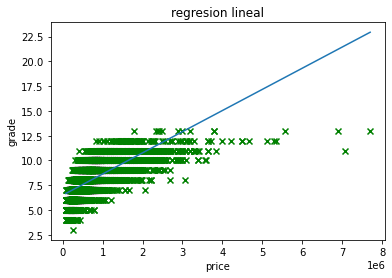

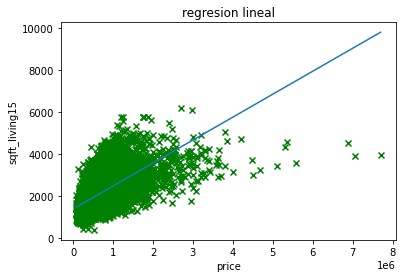

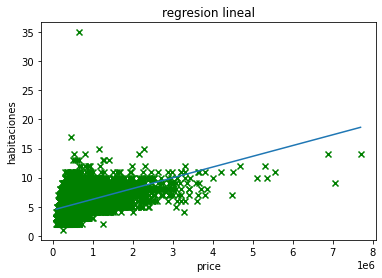

In [12]:
#Por la matriz de correlacion vemos que los unicos datos con los que el precio puede estar más relacionado es con los 
#metros cuadrados de vivienda, con la calidad y con el numero de habitaciones (sqft_living15, grade y habitaciones)
#Por tanto, vamos a probar la recta de regresión con esas tres columnas

x2 = df['price']

y6 = df['grade']
y7 = df['sqft_living15']
y8 = df['habitaciones']


x2_const = sm.add_constant(x2)

def regresion(y, x, xconst):  
    modelo = sm.OLS(y, xconst).fit()
    pred = modelo.predict(xconst)
    try:
        const = modelo.params[0]
        coef = modelo.params[1]
        x_l = np.linspace(x.min(), x.max(), 50)
        y_l = coef*x_l + const
    except:
        pass

    plt.plot(x_l, y_l, label = f'{x.name} vs {y.name} = {coef}*{x.name} + {const}')
    plt.scatter(x, y, marker = 'x', c = 'g', label = f'{x.name} vs {y.name}')
    plt.title('regresion lineal')
    plt.xlabel(f'{x.name}')
    plt.ylabel(f'{y.name}')
    plt.show()

regresion(y6, x2, x2_const)
regresion(y7, x2, x2_const)
regresion(y8, x2, x2_const)
#Se observa en las gráficas que la recta está descuadrada debido a los valores atípicos. Vamos a eliminar estos valores y a volverlo a intentar


[ 7  6  8 11  9  5 10 12  4  3 13]


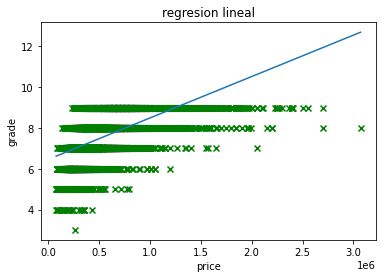

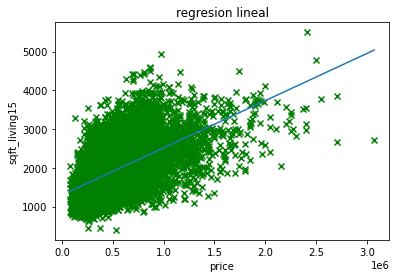

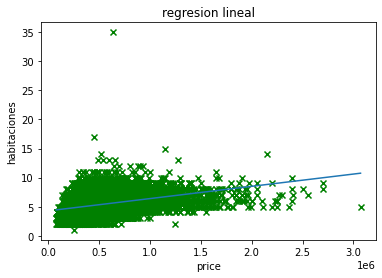

In [13]:
print(df['grade'].unique()) #A partir del 10, aparecen muy poco, son filas que podemos eliminar
for i in range(len(df['grade'])):
    if df['grade'][i] > 9:
        df = df.drop([i], axis = 0)
x2 = df['price']

y6 = df['grade']

x2_const = sm.add_constant(x2)
regresion(y6, x2, x2_const)
#Vemos que, aún así, no nos sirve como referente para una regresión lineal, ya que la disposición de los datos no se acerca a una recta.

a = df['sqft_living15'].unique()


y7 = df['sqft_living15']
regresion(y7, x2, x2_const)

y8 = df['habitaciones']
regresion(y8, x2, x2_const)
#Una vez quitadas esas filas, solucionamos el problema en las dos gráficas.
#Las que más se pueden acercar a una linea es la sqft_living15 y habitaciones

In [16]:
#Por tanto, entrenaremos nuestro modelo con esas columnas

y = df['price']
x = df.drop(['price','id', 'sqft_lot15', 'floors', 'waterfront', 'condition', 'yr_built', 'grade'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

logreg = LogisticRegression(max_iter= 100)

logreg.fit(x_train, y_train)
scoretrain = logreg.score(x_train, y_train)
scoretest = logreg.score(x_test, y_test)

dicc = {'Train_score: ': scoretrain,
       'Test_score: ': scoretest}
print(dicc)

{'Train_score: ': 0.007827666103074707, 'Test_score: ': 0.007262709742048585}


In [15]:

accuracy_score_train = accuracy_score(y_train, logreg.predict(x_train))
print('ACCURACY SCORE TRAIN')
print(accuracy_score_train)

accuracy_score_test = accuracy_score(y_test, logreg.predict(x_test))
print('ACCURACY SCORE TEST')
print(accuracy_score_test)
#Podemos observar que con los datos actuales no podemos hacer una prediccion del precio de la casa, aunque los valores se ajusten a una regresión lineal 

ACCURACY SCORE TRAIN
0.008766986035443671
ACCURACY SCORE TEST
0.0067618332081141996
